In [3]:
%cd turnus
%load_ext autoreload
%autoreload 2

[Errno 2] No such file or directory: 'turnus'
/home/dmatis/s/ssd/rl-optimization/turnus


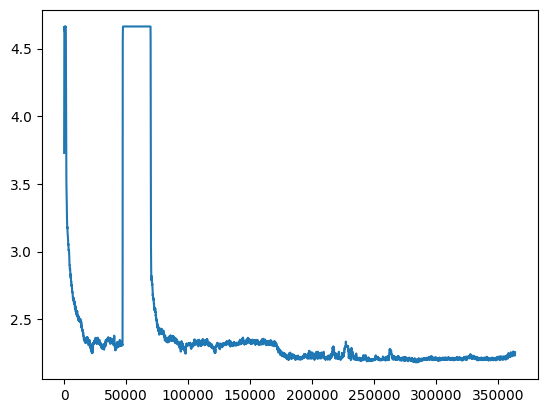

In [4]:
from IPython.display import clear_output
import time
import pandas as pd
import matplotlib.pyplot as plt

while True:
    clear_output(wait=True)
    df = pd.read_csv('results/data/ppo.csv')
    plt.plot(df['episode'], df['avg_score'])
    plt.show()
    time.sleep(5)

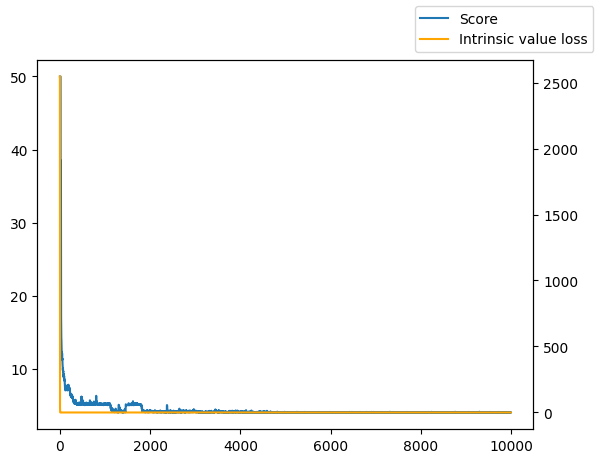

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

training = 4
df = pd.read_csv(f'results/data/ppo_{training}.csv')
df2 = pd.read_csv(f'results/data/ppo_{training}_loss.csv')
fig, ax1 = plt.subplots()

ax1.plot(df['iteration'], df['avg_score'], label='Score')
ax2 = ax1.twinx()

# ax2.plot(df2['iteration'], df2['ext_value'], c='green', label='Extrinsic value loss')
ax2.plot(df2['iteration'], df2['int_value'], c='orange', label='Intrinsic value loss')
fig.legend()

In [29]:
import torch
from env import Env
import utils.graph_utils as graph_utils
from model import GCNPolicy
from utils.utils import reward_to_obj
from torch_geometric.data import Data

def evaluate(model: str, env: Env):
    net = GCNPolicy(env.state_space(), env.action_space()).to(device)
    state_dict = torch.load(model)
    net.load_state_dict(state_dict)
    net.eval()

    observation, mask = env.reset()
    terminal = False

    r_sum = 0
    while not terminal:
        logit, ext_value, int_value = net(observation)
        logit = torch.where(mask, logit, torch.tensor(-1e+8, device=device))
        action = logit.argmax()
        observation, mask, reward, terminal, _ = env.step(action.item())
        r_sum += reward

    return observation, r_sum, reward_to_obj(r_sum, env.optimal_vehicles, env.MAX_VEHICLES)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
graph, optimal = graph_utils.load_problem('data/1')

env = Env(graph, device)
observation, _, vehicles = evaluate('results/models/ppo_1_975.pt', env)
vehicles

5.0

In [30]:
def get_tours_by_vehicles(graph: Data, env: Env):
    vehicles = {}
    for i in range(graph.num_nodes):
        node = graph.x[i]
        vehicle = (node[env.flag_visited_index] * env.MAX_VEHICLES).item()

        if vehicle != int(vehicle):
            raise ValueError("Vehicle ID is not an integer")

        vehicle = int(vehicle)

        if str(vehicle) not in vehicles:
            vehicles[str(vehicle)] = []

        vehicles[str(vehicle)].append(i)

    return vehicles

get_tours_by_vehicles(observation.cpu(), env)

{'0': [0, 50],
 '4': [1, 5, 8, 12, 19, 31, 34, 39, 42, 44],
 '2': [2, 6, 10, 16, 20, 21, 26, 27, 30, 38, 43, 46],
 '3': [3, 9, 14, 24, 25, 32, 40, 45],
 '1': [4, 7, 11, 15, 18, 22, 29, 35, 37, 47, 48, 49],
 '5': [13, 17, 23, 28, 33, 36, 41]}

In [31]:
def get_result_subgraph(graph: Data, env: Env):
    vehicle_tours = get_tours_by_vehicles(graph, env)

    edges = []
    for vehicle, node_ids in vehicle_tours.items():
        if vehicle == '0':
            continue
        
        for i in range(len(node_ids) - 1):
            if i == 0:
                edges.append([vehicle_tours['0'][0], node_ids[0]])
            elif i == len(node_ids) - 2:
                edges.append([node_ids[i+1], vehicle_tours['0'][1]])

            edges.append([node_ids[i], node_ids[i+1]])

    edges = torch.tensor(edges)

    return Data(x=graph.x, edge_index=edges.t().contiguous())

get_result_subgraph(observation.cpu(), env)

Data(x=[51, 7], edge_index=[2, 54])

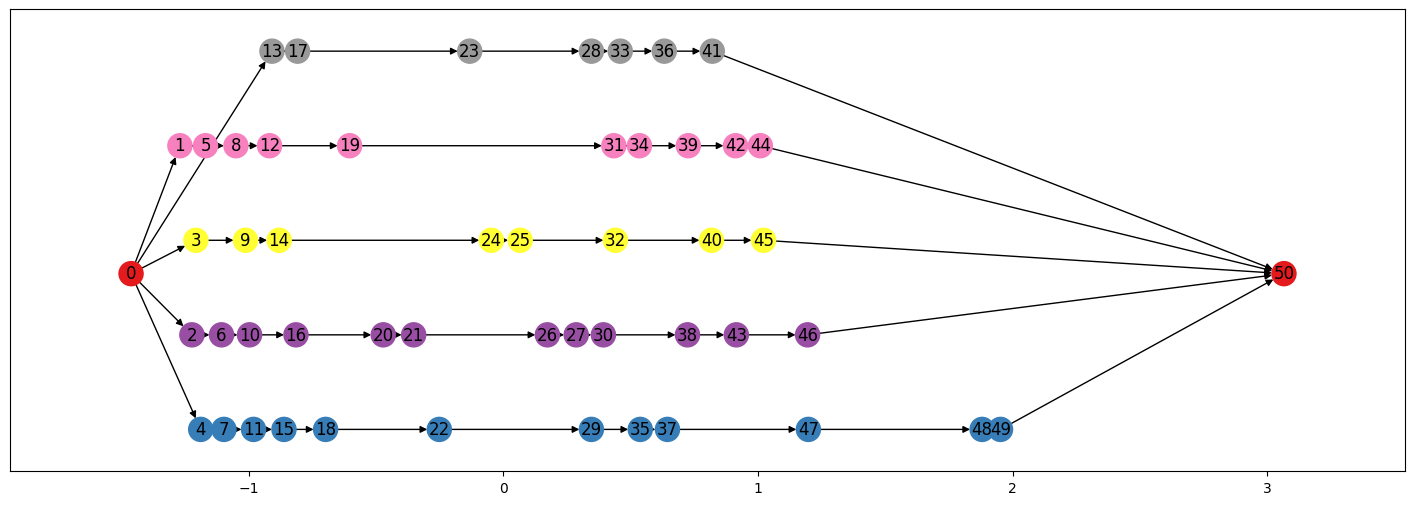

In [33]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import numpy as np

def draw_graph_by_vehicles(graph: Data, env: Env):
    node_labels = graph.x[:, env.flag_visited_index].numpy()
    positions = {}

    center = np.mean(node_labels)

    for i in range(graph.num_nodes):
        node = graph.x[i]
        if node[env.flag_visited_index] == 0:
            positions[i] = [node[2], center]
        else:
            positions[i] = [node[2], node[env.flag_visited_index]]

    g = to_networkx(graph)

    fig, ax = plt.subplots(1, 1, figsize=(18,6))
    nx.draw(g, pos=positions, cmap=plt.get_cmap('Set1'), node_color=node_labels, with_labels=True, ax=ax)
    limits=plt.axis('on')
    ax.tick_params(left=False, bottom=True, labelleft=False, labelbottom=True)

observation, _, vehicles = evaluate('results/models/ppo_1_975.pt', env)
draw_graph_by_vehicles(get_result_subgraph(observation.cpu(), env), env)

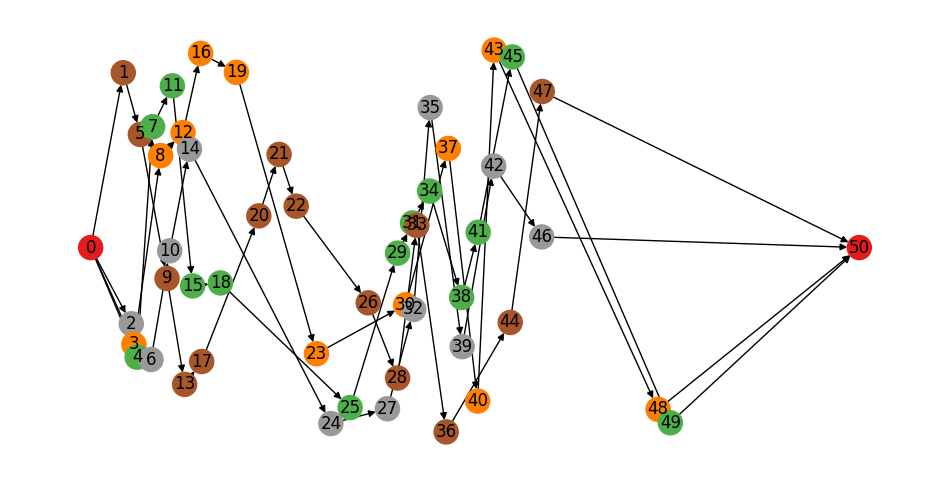

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def draw_graph(graph: Data, env: Env, info=""):
    node_labels = graph.x[:, env.flag_visited_index].numpy()
    positions = {}

    gen = np.random.default_rng(graph.num_nodes)

    mean = graph.x[:, 2].mean()

    for i in range(graph.num_nodes):
        node = graph.x[i]
        if i == 0 or i == graph.num_nodes - 1:
            positions[i] = [node[2].item(), mean]
        else:
            positions[i] = [node[2].item(), mean + (gen.random() - 0.5)]

    g = to_networkx(graph)

    pos = nx.layout.spring_layout(g, pos= positions)
    plt.figure(1,figsize=(12,6))
    plt.text(1, 1, info) 
    nx.draw(g, pos=positions, cmap=plt.get_cmap('Set1'), node_color=node_labels, with_labels=True)

def draw_result(model: str, env: Env):
    observation, _, vehicles = evaluate(model, env)
    draw_graph(get_result_subgraph(observation.cpu(), env), env, f"Vehicles: {vehicles}")

draw_graph(get_result_subgraph(observation.cpu(), env), env)

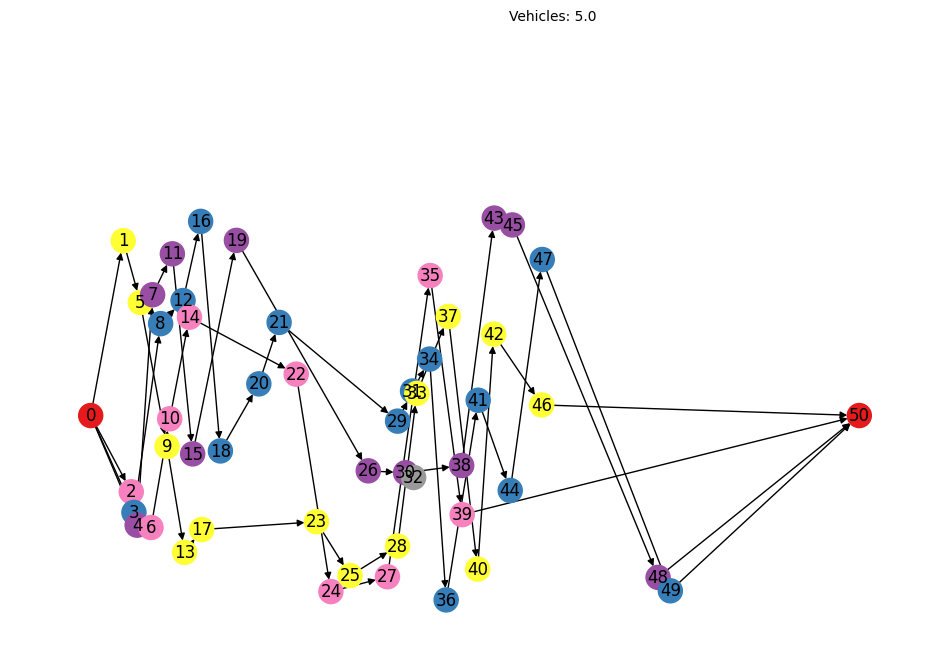

In [14]:
draw_result('results/models/ppo_1021_ppo.pt', env)